# DSL Winter Project 2022/2023: Speech Recognition

---

In [1]:
import pandas as pd
import numpy as np
import scipy.io as wavfile
import scipy.io
import librosa
import librosa.display as ldisp
import random
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import sklearn as sk

plt.rcParams['figure.dpi'] = 200

#### Data loading

In [3]:
path = 'dsl_data/development.csv'

df = pd.read_csv(path, index_col=0)
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,dsl_data/audio/speakers/M4ybygBlWqImBn9oZ/5449...,M4ybygBlWqImBn9oZ,decrease,volume,native,English (United States),English (United States),female,22-40
1,dsl_data/audio/speakers/eL2w4ZBD7liA85wm/aa692...,eL2w4ZBD7liA85wm,deactivate,lights,native,English (United States),English (United States),male,22-40
2,dsl_data/audio/speakers/AY5e3mMgZkIyG3Ox/ff7f8...,AY5e3mMgZkIyG3Ox,increase,volume,native,English (United States),English (United States),male,22-40
3,dsl_data/audio/speakers/xwpvGaaWl5c3G5N3/64c10...,xwpvGaaWl5c3G5N3,increase,heat,native,English (United States),English (United States),female,22-40
4,dsl_data/audio/speakers/7NqqnAOPVVSKnxyv/25d40...,7NqqnAOPVVSKnxyv,activate,music,native,English (United States),English (United States),male,22-40
5,dsl_data/audio/speakers/xEYa2wgAQof3wyEO/586ab...,xEYa2wgAQof3wyEO,activate,music,native,English (United States),English (United States),male,22-40
6,dsl_data/audio/speakers/eBQAWmMg4gsLYLLa/d9498...,eBQAWmMg4gsLYLLa,decrease,heat,native,English (United States),English (United States),female,22-40
7,dsl_data/audio/speakers/eBQAWmMg4gsLYLLa/b9be6...,eBQAWmMg4gsLYLLa,activate,music,native,English (United States),English (United States),female,22-40
8,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/9e5f9...,2BqVo8kVB2Skwgyb,decrease,volume,advanced,English (United States),English (United States),female,22-40
9,dsl_data/audio/speakers/neaPN7GbBEUex8rV/310d5...,neaPN7GbBEUex8rV,increase,heat,native,English (United States),English (United States),female,41-65


#### Audio Outuput example

In [4]:
path_speaker = 'dsl_data/audio/speakers'
speaker_id_list = df['speakerId'].unique()

*Set speaker and file*

In [5]:
speaker_id = ''
file_WAV_path = ''

*speaker and file set to random if null*

In [6]:
if speaker_id == '':
    speaker_id = df['speakerId'].unique()[random.randint(0, df['speakerId'].unique().size)]

if file_WAV_path == '':
    file_WAV_path = df['path'][random.randint(0, df['path'].size)]

action = df[df['path'] == file_WAV_path]['action'].values[0]
object = df[df['path'] == file_WAV_path]['object'].values[0]
ind = df[df['path'] == file_WAV_path].index[0]
fWp2 = file_WAV_path

In [7]:
from scipy.fftpack import fft, fftfreq, ifft
import warnings

def frequency_domain(data, sr, f_min, f_max):

    spectrum = fft(data)
    F = fftfreq(data.size, d=1/sr)
    # voice range in 300 Hz - 3400Hz
    Fpositive = np.where((F >= f_min) & (F <= f_max))
    return spectrum, F, Fpositive

def spectrogram(data):
    D = librosa.stft(data)  # short time fourier transfor
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_db

def mel_spectrogram(data, sr, N, hl):
    mel_spect = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=N, hop_length=1024)
    S_db = librosa.power_to_db(mel_spect, ref=np.max)
    return S_db


def plot(file_WAV, data, data2: np.ndarray, S_db, spectrum, F, Fpositive, N, sr, sr2):
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    plt.rcParams["figure.figsize"] = (15, 10)
    plt.title(f'{file_WAV}')

    # data in time (s)
    ax0 = plt.subplot(221)
    ax0.set_title(f'{file_WAV}')
    x_axis = np.linspace(0, data2.size/sr2, data2.size)
    ax0.set_xlabel('Time (s)')
    ax0.set_ylabel('Amplitude')
    ax0.plot(x_axis, data2)

    # data in frequency (Hz)
    ax1 = plt.subplot(222)
    ax1.set_title(f'{file_WAV}')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Magnitude')
    ax1.plot(F[Fpositive], np.absolute(spectrum[Fpositive])/N)

    # data in spectogram
    ax2 = plt.subplot(212)
    ax2.set_title(f'{file_WAV}')
    ax2.set_xlabel('time (s)')

    img2 = ldisp.specshow(S_db, y_axis='log', sr=sr, x_axis='time', ax=ax2)
    plt.colorbar(img2, ax=ax2, format="%+2.f dB")
    plt.gca().set_xlabel("Time (s)")
    plt.gca().set_ylabel("Frequency (Hz)")
    
    plt.show()


def print_audio(file_WAV_path, speaker_id, action, object, index):

    # Info
    file_WAV = file_WAV_path.split(os.sep)[-1]
    print(f'File audio: {file_WAV}')
    print(f'Speaker: {speaker_id}')
    print(f'Index in df: {index}')
    print()
    print(f'Action: {action}')
    print(f'Object: {object}')
    print()

    # Audio data
    data, sr = librosa.load(file_WAV_path)
    sr2, data2 = scipy.io.wavfile.read(file_WAV_path)
    data2 = np.array(data2)
    N = data.size
    N2 = data2.size
    print(f'shape: {data.shape}')
    print(f'sr: {sr} Hz')

    # Frequency domain
    spectrum, F, Fpositive = frequency_domain(data2, sr2, 0, 5000)

    # Spectogram
    S_db = spectrogram(data)
    #S_db = mel_spectrogram(data, sr, N, hl=1024)

    # Plots
    plot(file_WAV, data, data2, S_db, spectrum, F, Fpositive, N, sr, sr2)

#### Audio outupt

In [13]:
# Play audio file
ipd.Audio(file_WAV_path)

File audio: 6c6303e0-451c-11e9-9035-7943ec3b842a.wav
Speaker: YbmvamEWQ8faDPx2
Index in df: 9091

Action: decrease
Object: heat

shape: (53248,)
sr: 22050 Hz


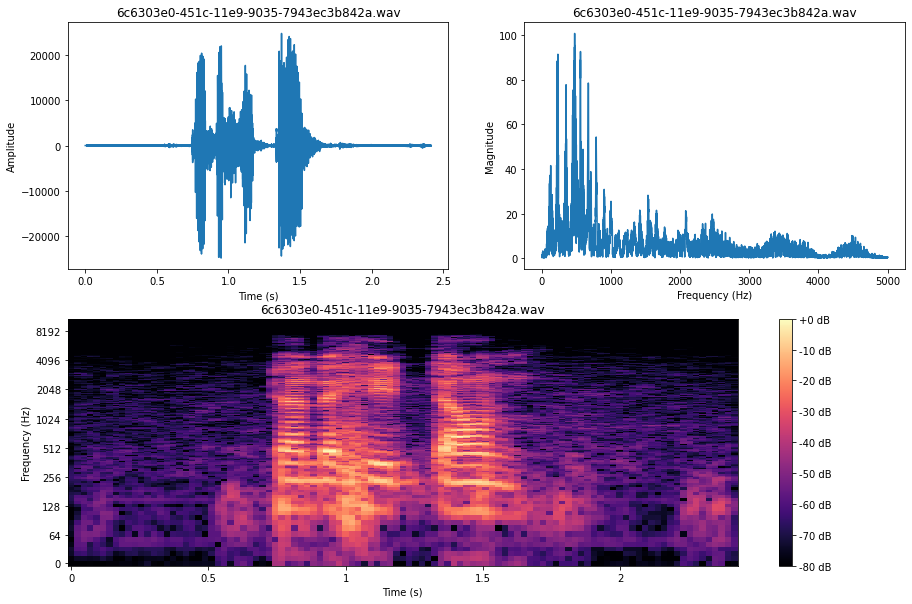

In [9]:
print_audio(file_WAV_path, speaker_id, action, object, ind)

#### Preprocessing

Trimming and normalization of the wav files

In [15]:
from scipy import signal

def get_class(action: str, object: str):
    return action + object

#high-pass filter
def f_high(y, sr):
    f_cut = 250
    b, a = signal.butter(10, f_cut/(sr/2), btype='highpass')
    yf = signal.lfilter(b, a, y)
    return yf


def bandPassFilter(signal, sr):

    lowcut = 300  # to set
    highcut = 4500 # to set
    low = lowcut / (sr/2)
    high = highcut / (sr/2)
    order = 2
    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
    y = scipy.signal.filtfilt(b, a, signal, axis=0)

    return(y)

In [ ]:
size = df['path'].size
data_proccessed = [0]*size
sr_list = [0]*size
class_list = ['']*size

n_bit = 16

for i, file_WAV_path in enumerate(df['path']):
    
    sr, data = scipy.io.wavfile.read(file_WAV_path)
    data = np.array(data, dtype=np.float32)

    # 1. High-pass filtering above 300 Hz (Human voice range)
    data = bandPassFilter(data, sr)

    # 2. Normalization: to match librosa out == scipy output
    data /= 2**(n_bit-1) 

    # 3. Audio trimming
    trimmed_data, _ = librosa.effects.trim(data, top_db=25)
    

    # Insert processed audio in data structure
    data_proccessed[i] =  trimmed_data

    sr_list[i] = sr
    action = df.iloc[i]['action']
    object = df.iloc[i]['object']
    class_list[i] = get_class(action, object)

    print(f'\nFile {i+1}/{size} processed -- {round((i+1)*100/size, 3)} %', end='\r')

data_proccessed = np.array(data_proccessed)
sr_list = np.array(sr_list)
print('\n✅ All data processed')

In [17]:
class_list = np.array(class_list)

#### Dataset Analysis

Audio durations distribution

In [ ]:
durations = [0]*size

for h, data in enumerate (data_proccessed):
    duration = len(data)/sr_list[h]
    durations[h]= duration

In [ ]:
minD = min(durations) 
maxD = max(durations)
print (f'{minD}, {maxD}')

In [ ]:
# Plot the distribution of durations

#plt.rcParams["figure.figsize"] = (10, 5)

bins = np.linspace(min(durations), max(durations), 10)

plt.hist(durations, bins=bins,log= True)
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.title('Distribution of Durations')
plt.show()

In [ ]:
std_dev_duration = np.std(durations)

# print the result
print("The std of the durations is: ", std_dev_duration)

The standard deviation is a measure of the spread of a distribution, and it is often used in conjunction with the mean to describe the distribution of a dataset.

In [ ]:
cv_duration = std_dev_duration / np.mean(durations) * 100

# print the result
print("The coefficient of variation of the durations is: ", cv_duration, "%")

The CV is the ratio of the standard deviation to the mean, multiplied by 100. It is a normalized measure of variability and it is expressed as a percentage. It is useful when comparing variability across different datasets that have different means.

Audio rate distribution

In [ ]:
unique_values, counts = np.unique(sr_list, return_counts=True)

# Print the resulting counts
for value, count in zip(unique_values, counts):
    print(f"Value {value} occurs {count} times")

Labels distribution

In [ ]:
# Select the attribute by its column name
attribute = df['action']+df['object']

# Use the value_counts() function to count the occurrences of the attribute
attribute_counts = attribute.value_counts()

# Print the resulting counts
print(attribute_counts)

#### PROCESSED Audio Output Example

In [18]:
ipd.Audio(data_proccessed[ind],rate=sr_list[ind])

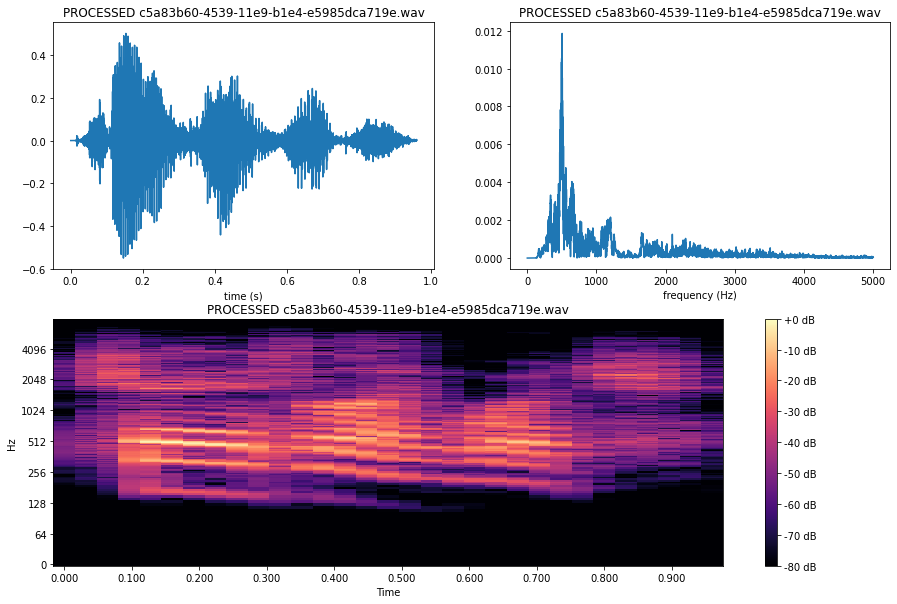

In [19]:
spectrum, F, Fpositive = frequency_domain(data_proccessed[ind], sr_list[ind], 0, 5000)
S_db = spectrogram(data_proccessed[ind])

plot(f'PROCESSED {fWp2.split(os.sep)[-1]}', data_proccessed[ind],
     data_proccessed[ind], S_db, spectrum, F, Fpositive, data_proccessed[ind].size, sr_list[ind], sr_list[ind])


### Feature Matrix creation

Hyperparameters

In [20]:
n_mfccs = 7
n_blocks = 20
hl_den = 8  # hop_lenght for mfccs: max 2^9 = 512

In [21]:
n_features = n_mfccs * n_blocks * 2

In [22]:
feature_matrix = np.empty((data_proccessed.shape[0], n_features))
feature_matrix.shape

(9854, 280)

Features extraction

In [23]:
def mfccs_extractor(data, sr, n_mfccs):
    mfccs_features = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfccs, hop_length=512//hl_den)
    return mfccs_features

def mfccs_mean(mfccs_features):
    return np.mean(mfccs_features.T, axis=0)

MFCCs example plot

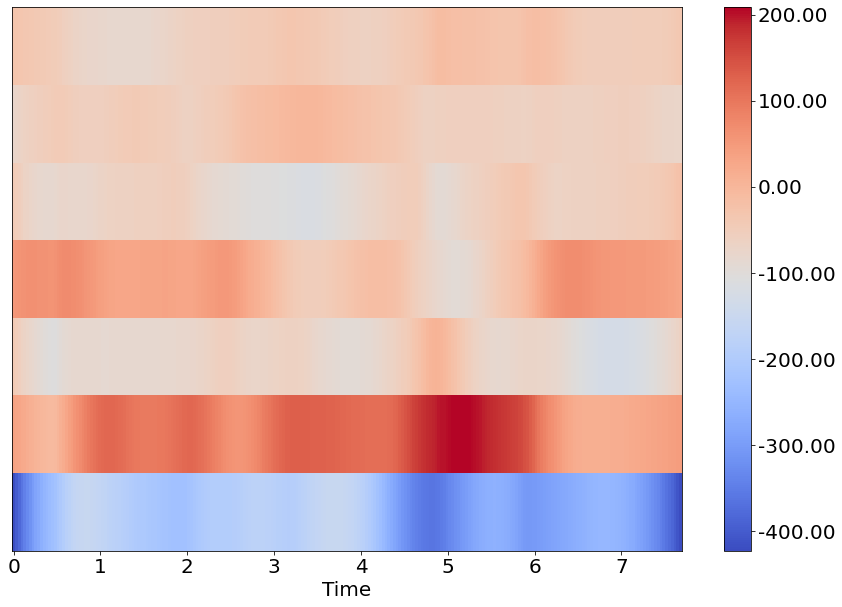

In [24]:
mfcc_example = mfccs_extractor(data_proccessed[ind], sr_list[ind], n_mfccs)
disp =  ldisp.specshow(mfcc_example, x_axis='time',sr=sr)
disp.axes.tick_params(labelsize=20)
disp.axes.set_xlabel('Time', size=20)
plt.colorbar(format='%.2f').ax.tick_params(labelsize=20)
plt.show()

In [25]:
print(f'Features for audio {file_WAV_path.split(os.sep)[-1]}')
mfccs_mean(mfcc_example)

Features for audio a10a1810-4470-11e9-a9a5-5dbec3b8816a.wav


array([-245.01897845,   96.31965139,  -77.02533067,   10.24863272,
        -69.98613328,  -45.83091246,  -46.65134284])

#### Feature extraction for whole Dataset

In [26]:
def get_mfccs_blocks(mfccs: np.ndarray, n_blocks):

    mfccs_blocks_mean = np.empty((mfccs.shape[0], n_blocks))
    mfccs_blocks_std = np.empty((mfccs.shape[0], n_blocks))

    for i in range(mfccs.shape[0]):
        row = np.array(np.array_split(mfccs[i], n_blocks))
        if (row.size < n_blocks):
            print(f'AAAAAAAAAA: {arr.size} < {n_blocks}')
        for j, arr in enumerate(row):
            arr = np.array(arr)
            mfccs_blocks_mean[i][j] = arr.mean()
            mfccs_blocks_std[i][j] = arr.std()

    return mfccs_blocks_mean, mfccs_blocks_std


def mfccs_blocks_To_features(mfccs_blocks: np.ndarray):
    return mfccs_blocks.reshape((mfccs_blocks.size))

In [27]:
for i, data in enumerate(data_proccessed):
    mfcc = mfccs_extractor(data, sr_list[i], n_mfccs)
    mfccs_blocks_mean, mfccs_blocks_std = get_mfccs_blocks(mfcc, n_blocks)
    mfccs_blocks = np.append(mfccs_blocks_mean, mfccs_blocks_std, axis=1)
    features = mfccs_blocks_To_features(mfccs_blocks)

    # mfcc = mfccs_mean(mfcc)
    feature_matrix[i] = features # np.concatenate((mfcc_example, mfcc_example_d1, mfcc_example_d2))
    print(f'data {i+1}/{size} MFCCs extracted -- {round((i+1)*100/size, 3)} %', end='\r')

/var/folders/qj/_vcxrhks50v5f7x15kwlmmg40000gn/T/ipykernel_34339/897206639.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  row = np.array(np.array_split(mfccs[i], n_blocks))


In [28]:
feature_matrix.shape

(9854, 280)

### Get X_eval form evaluation.csv

In [29]:
def get_X_eval():

    df_eval = pd.read_csv('dsl_data/evaluation.csv', index_col=0)

    size_eval = df_eval['path'].size
    data_proccessed_eval = [0]*size_eval
    sr_list_eval = [0]*size_eval
    feature_matrix_eval = np.empty((len(data_proccessed_eval), n_features))

    n_bit = 16

    for i, file_WAV_path in enumerate(df_eval['path']):

        # Preprocessing
        sr_eval, data_eval = scipy.io.wavfile.read(file_WAV_path)
        data_eval = np.array(data_eval, dtype=np.float32)

        # 1. High-pass filtering above 300 Hz (Human voice range)
        data_eval = bandPassFilter(data_eval, sr_eval)

        # 2. Normalization: to match librosa out == scipy output
        data_eval /= 2**(n_bit-1)

        # 3. Audio trimming
        trimmed_data_eval, _ = librosa.effects.trim(data_eval, top_db=25)
        
        data_proccessed_eval[i] = trimmed_data_eval

        sr_list_eval[i] = sr_eval

        # Feature extraction
        mfcc_eval = mfccs_extractor(data_proccessed_eval[i], sr_list_eval[i], n_mfccs)
        mfccs_blocks_eval_mean, mfccs_blocks_eval_std = get_mfccs_blocks(mfcc_eval, n_blocks)
        mfccs_blocks_eval = np.append(mfccs_blocks_eval_mean, mfccs_blocks_eval_std, axis=1)
        features_eval = mfccs_blocks_To_features(mfccs_blocks_eval)

        # mfcc = mfccs_mean(mfcc)
        feature_matrix_eval[i] = features_eval

        print(
            f'File eval {i+1}/{size_eval} processed -- {round((i+1)*100/size_eval, 3)} %', end='\r')

    sr_list_eval = np.array(sr_list_eval)
    data_proccessed_eval = np.array(data_proccessed_eval)

    print('\n✅ All data processed')

    return feature_matrix_eval

### Model training

Train, Test

In [30]:
X = feature_matrix
y = class_list
X.shape, y.shape

((9854, 280), (9854,))

In [139]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_eval = np.empty((0))

X_eval

In [31]:
X_eval = get_X_eval()

/var/folders/qj/_vcxrhks50v5f7x15kwlmmg40000gn/T/ipykernel_34339/897206639.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  row = np.array(np.array_split(mfccs[i], n_blocks))


File eval 1455/1455 processed -- 100.0 %%
✅ All data processed


/var/folders/qj/_vcxrhks50v5f7x15kwlmmg40000gn/T/ipykernel_34339/643604155.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_proccessed_eval = np.array(data_proccessed_eval)


In [32]:
X_train = X
y_train = y

X_test = np.empty((0))
y_test = np.empty((0))

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_eval.shape

((9854, 280), (0,), (9854,), (0,), (1455, 280))

Test

### Feature extraction for Evaluation Dataset

In [34]:
from sklearn.model_selection import ParameterGrid

params = {
    'n_estimators': [1000],  # always better for n_estimators increasing
    "max_depth": [None],
    'criterion': ['entropy', 'log_loss'] # entropy seems always the best
    }

grid = ParameterGrid(params)
i_to_config ={}
i=0
for config in grid:
    i_to_config[i] = config
    i+=1

In [35]:
i_to_config

{0: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 1000},
 1: {'criterion': 'log_loss', 'max_depth': None, 'n_estimators': 1000}}

*Choose config*

In [36]:
i = 0

### Model fit and predict

Fit

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()

clf = GridSearchCV(rfc, params, verbose=10, cv=2)
 
# fit
clf.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2; 1/2] START criterion=entropy, max_depth=None, n_estimators=1000........
[CV 1/2; 1/2] END criterion=entropy, max_depth=None, n_estimators=1000;, score=0.689 total time= 1.8min
[CV 2/2; 1/2] START criterion=entropy, max_depth=None, n_estimators=1000........
[CV 2/2; 1/2] END criterion=entropy, max_depth=None, n_estimators=1000;, score=0.708 total time= 1.8min
[CV 1/2; 2/2] START criterion=log_loss, max_depth=None, n_estimators=1000.......
[CV 1/2; 2/2] END criterion=log_loss, max_depth=None, n_estimators=1000;, score=0.689 total time= 1.9min
[CV 2/2; 2/2] START criterion=log_loss, max_depth=None, n_estimators=1000.......
[CV 2/2; 2/2] END criterion=log_loss, max_depth=None, n_estimators=1000;, score=0.709 total time= 1.8min


GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'log_loss'],
                         'max_depth': [None], 'n_estimators': [1000]},
             verbose=10)

Best parameters

In [39]:
print("\n The best parameters across ALL searched params:\n",clf.best_params_)
print(f"\n CV results: \n {clf.best_score_}")


 The best parameters across ALL searched params:
 {'criterion': 'log_loss', 'max_depth': None, 'n_estimators': 1000}

 CV results: 
 0.6988025167444692


Predict (X_test)

In [111]:
# predict X_test
y_pred = clf.predict(X_test)
y_pred

array(['increasevolume', 'decreaseheat', 'increasevolume', ...,
       'decreaseheat', 'decreaseheat', 'decreasevolume'], dtype='<U19')

Predict (X_eval)

In [ ]:
# predict X_eval
y_ev_pred = clf.predict(X_eval)
y_ev_pred

### Metrics (train/test split)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Config: 

 {
    "criterion": "log_loss",
    "max_depth": null,
    "n_estimators": 1000
} 


                     precision    recall  f1-score   support

      activatemusic       0.86      0.73      0.79       161
change languagenone       0.82      0.81      0.82       210
   deactivatelights       0.98      0.46      0.63       121
       decreaseheat       0.73      0.52      0.61       228
     decreasevolume       0.78      0.75      0.77       512
       increaseheat       0.69      0.61      0.65       229
     increasevolume       0.63      0.88      0.74       510

           accuracy                           0.73      1971
          macro avg       0.79      0.68      0.71      1971
       weighted avg       0.75      0.73      0.73      1971



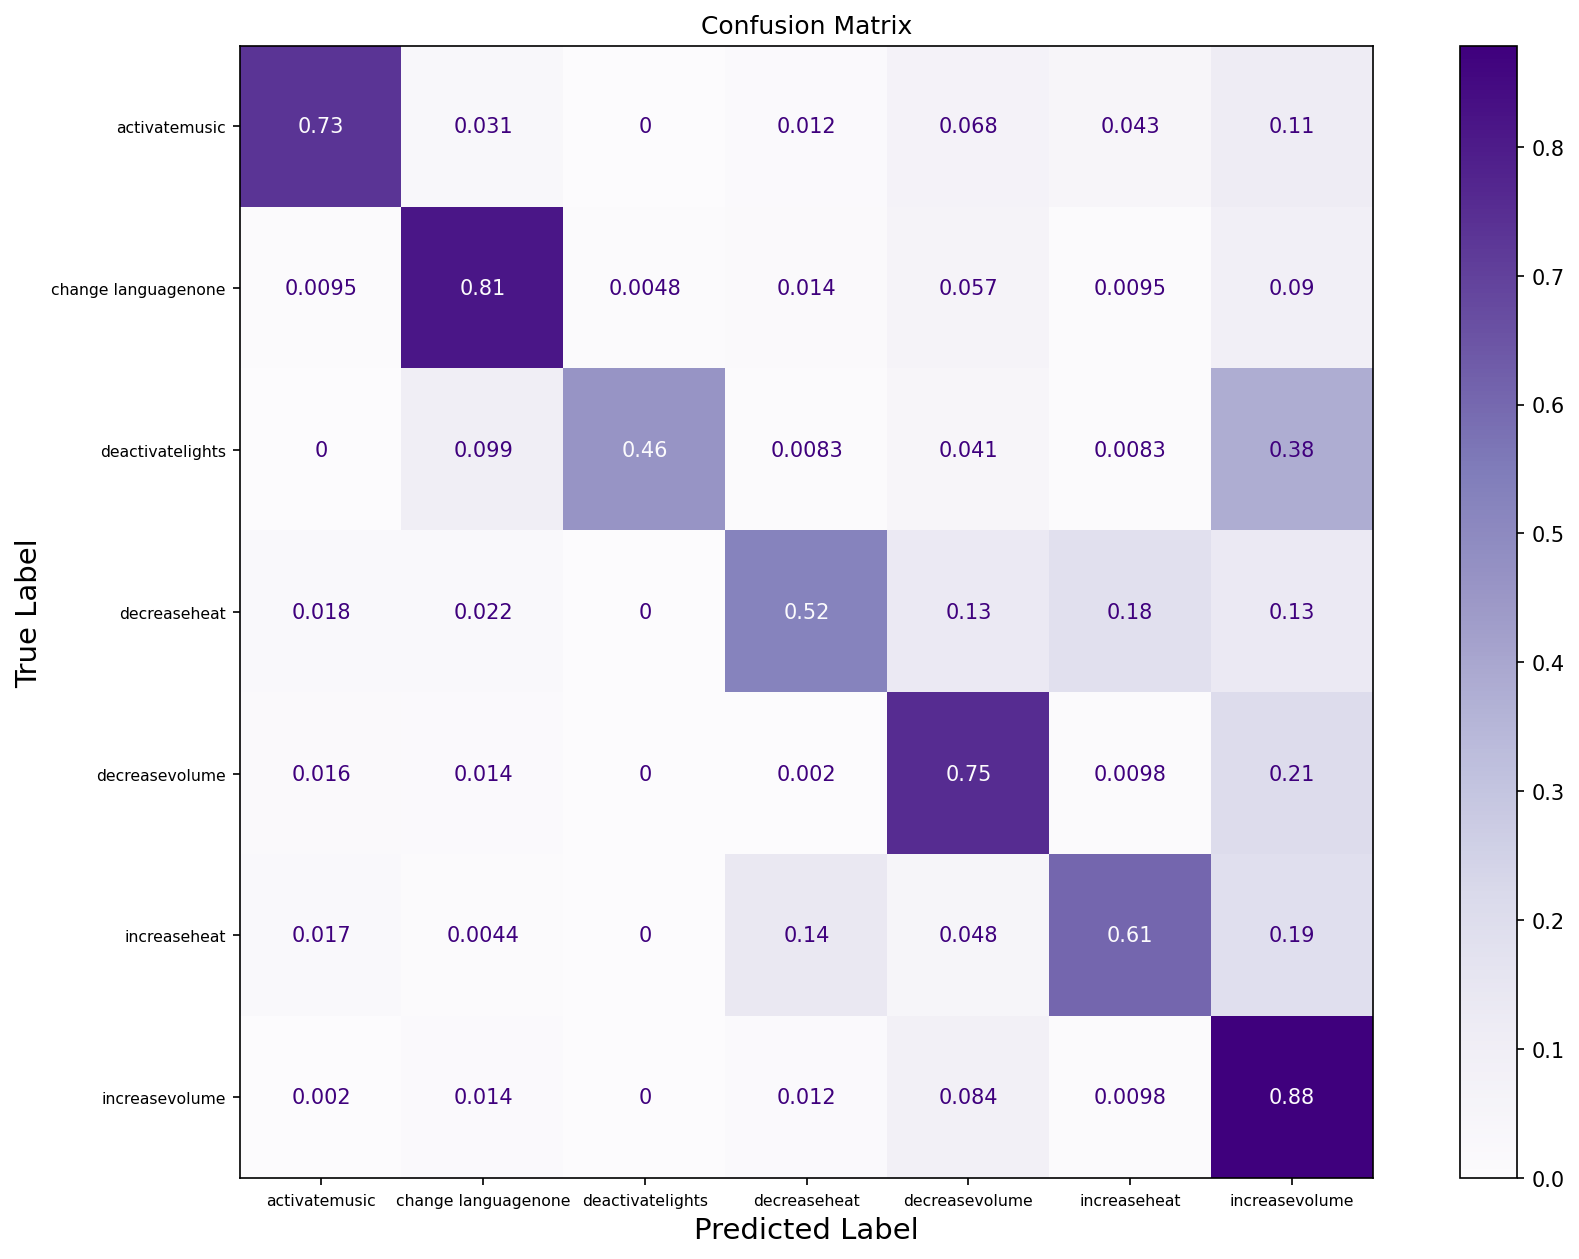

In [112]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

color = 'black'
matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Purples, normalize='true')

                                                                                                                                                                                                                                      
print(f'Config: \n\n {json.dumps(clf.best_params_, indent=4)} \n\n')

print(classification_report(y_test, y_pred, zero_division=0)) 

matrix.ax_.set_title('Confusion Matrix', color=color)
matrix.ax_.tick_params(axis='both', which='major', labelsize=7.5)
plt.xlabel('Predicted Label', color=color, fontsize=14)
plt.ylabel('True Label', color=color, fontsize=14)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

### CSV export

In [ ]:
getCSV = 1

In [ ]:
import datetime

ct = str(datetime.datetime.now())

In [ ]:
CSVtitle_append = f"{clf.best_params_['criterion']}_{clf.best_params_['max_depth']}_{clf.best_params_['n_estimators']}" + \
    f"_bandpass_filter=300-4500_n_mfccs={n_mfccs}__n_blocks={n_blocks}__hl={512//hl_den}_mean_std_{ct}"
CSVtitle_append

In [ ]:
if getCSV:
    CSVtitle_append = '_' + CSVtitle_append
    file_export_name = f'submission{i}{CSVtitle_append}.csv'
    os.path.relpath

    df_to_export = pd.DataFrame(y_ev_pred)
    df_to_export.columns = ['Predicted']
    df_to_export.index.names = ['Id']
    df_to_export.to_csv(str(os.path.join('submissions', file_export_name)))